In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import multidim

Supervised Learning with CDER
================

CDER requires a collection of pointclouds, each pointcloud having a label (typically, a color).
In this example, we'll first create an artificial collection of pointclouds

In [2]:
clouds_all = []
labels_all = []

# Let's make 100 "green" pointclouds, with some shape
for _ in range(100):
    X = np.concatenate([np.random.randn(50,2),
                        0.2*np.random.randn(4,2)+np.array([[4,0]]),
                        0.2*np.random.randn(4,2)+np.array([[5,0]]),
                        0.2*np.random.randn(4,2)+np.array([[-3,0]]),
                        0.2*np.random.randn(4,2)+np.array([[-6,0]]),
                        np.random.rand(4,2) + np.array([[-0.25, 3]])
                       ], axis=0)
    clouds_all.append(X)
    labels_all.append("green")

# Let's make 120 "magenta" pointclouds, with some slightly different shape
for _ in range(120):
    X = np.concatenate([np.random.randn(48,2),
                        0.2*np.random.randn(5,2)+np.array([[3,0]]),
                        0.2*np.random.randn(5,2)+np.array([[6,0]]),
                        0.2*np.random.randn(5,2)+np.array([[-4,0]]),
                        0.2*np.random.randn(5,2)+np.array([[-5,0]]),
                        np.random.rand(4,2) + np.array([[-0.5, 3]])
                       ], axis=0)
    clouds_all.append(X)
    labels_all.append("magenta")
    
assert len(clouds_all) == len(labels_all) == 220

Samples
-------
Let's look at a few of the pointclouds
The way we made them, I know that the first 100 pointclouds are "green" and pointclouds 101 -- 220  are "magenta"

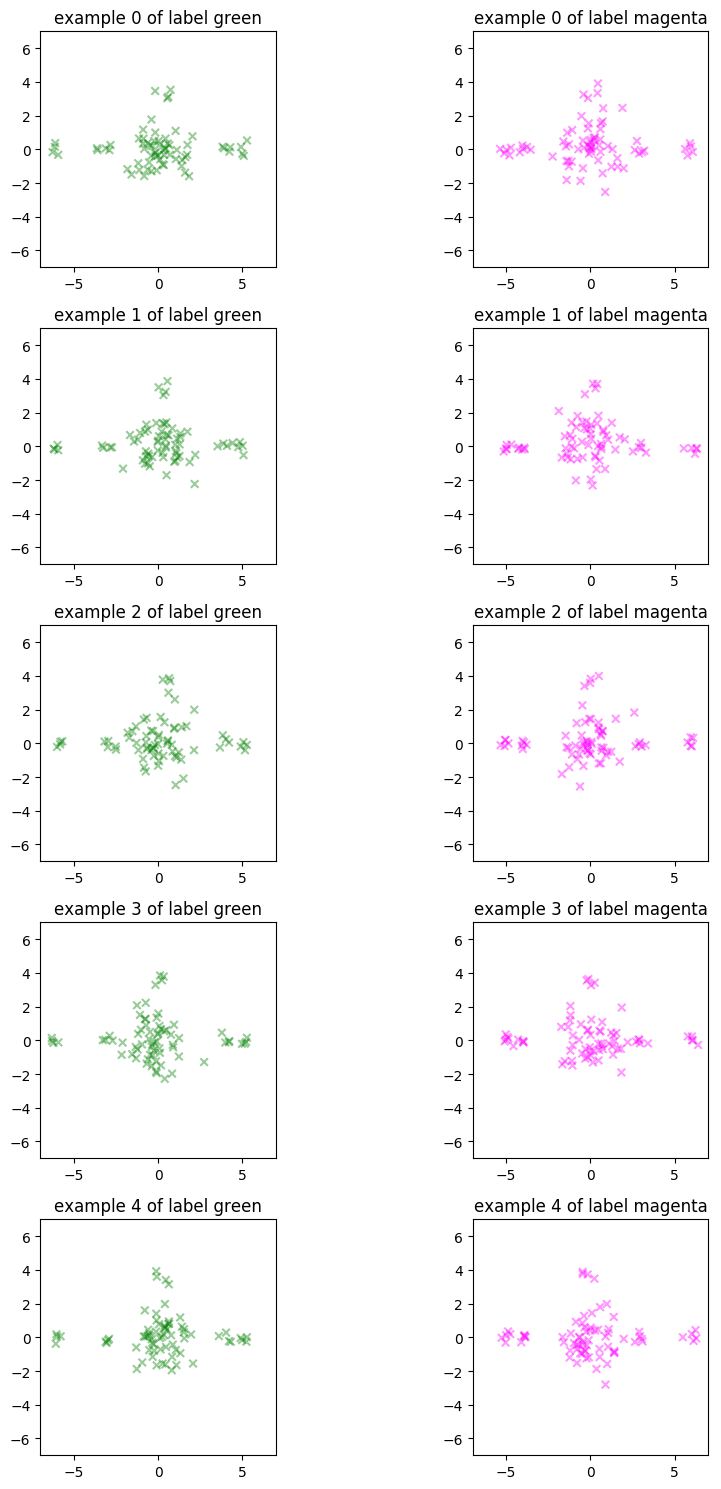

In [3]:

fig,ax = plt.subplots(5,2, figsize=(10,15), dpi=100)
for i in range(5):
    for j in range(2):
        counter = 100*j+i
        this_cloud = clouds_all[counter]
        this_label = labels_all[counter]
        # this lets me use the PointCloud plot command, colored by label.
        this_pc = multidim.PointCloud.from_multisample_multilabel([this_cloud], [this_label])
        this_pc.plot(ax[i,j], title="example {} of label {}".format(i, this_label))
        ax[i,j].set_aspect('equal')
        ax[i,j].set_xlim(-7,7)
        ax[i,j].set_ylim(-7,7)
plt.tight_layout()        
plt.show()

Training and Testing
----------
Let's split our samples into training and testing

In [4]:
from sklearn.model_selection import cross_val_score, train_test_split
clouds_train, clouds_test, labels_train, labels_test = train_test_split(clouds_all, labels_all, test_size=0.2,
        random_state=20160529)
print("Number of training sets: {}".format(len(clouds_train)))
print("Number of testing sets: {}".format(len(clouds_test)))


Number of training sets: 176
Number of testing sets: 44


Make the big pointcloud
----------------------

We now merge all of the training data into one big weighted, labelled PointCloud object

In [5]:
pc_train = multidim.PointCloud.from_multisample_multilabel(clouds_train, labels_train)
print(pc_train)
print(pc_train.label_info)

A SimplicialComplex with 12516 points, 0 edges, and 0 faces.
         clouds  points  weight  int_index
green        78    5460     1.0          0
magenta      98    7056     1.0          1


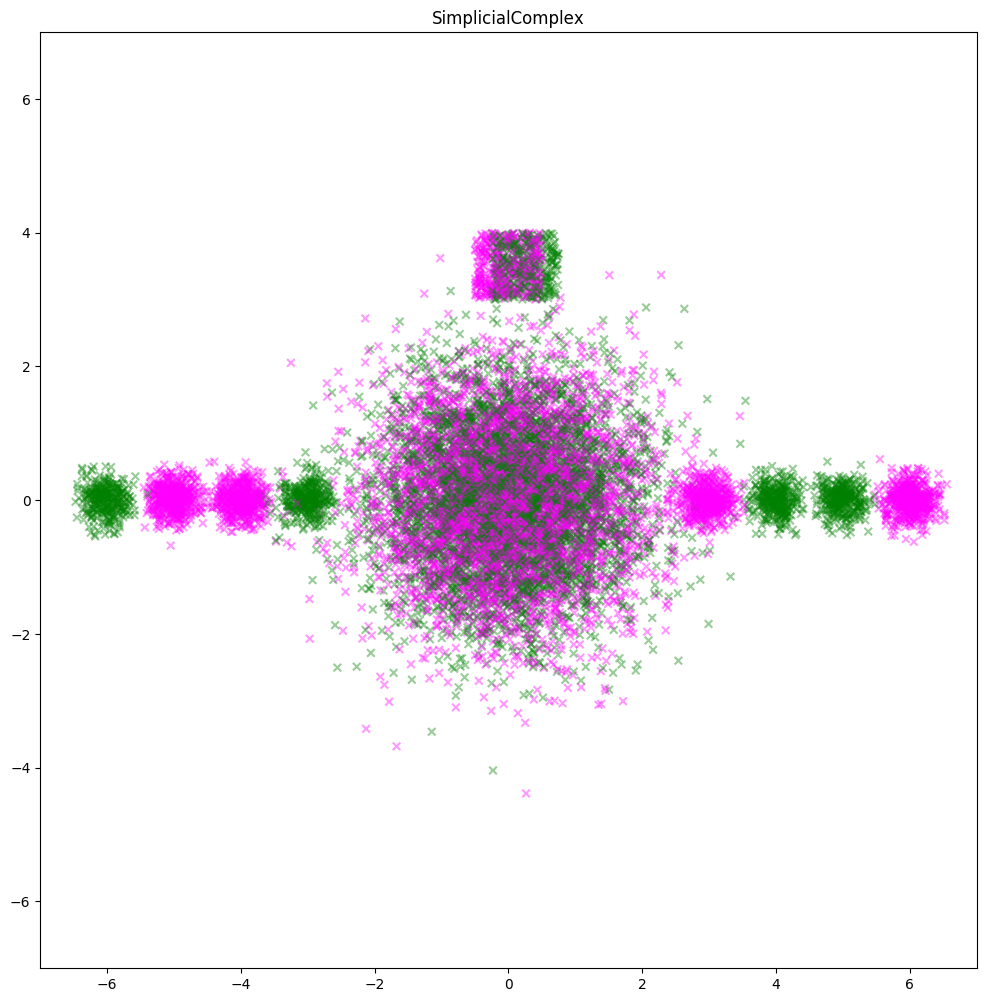

In [6]:
fig,ax = plt.subplots(figsize=(10,15), dpi=100)
pc_train.plot(ax)
ax.set_aspect('equal')
ax.set_xlim(-7,7)
ax.set_ylim(-7,7)
plt.tight_layout()
plt.show()

CoverTree
---------
Let's make a CoverTree of the data.  This isn't strictly necessary (CDER alone will only compute a partial tree).  However, it will help us visualize what is going on for the sake of the example.

In [7]:
from multidim.covertree import CoverTree
ct_train = CoverTree(pc_train)

# generating the cover tree will be the slow step.   I expect about 12 or 13 levels in this example.
# in fact, only level 5 or 6 is needed for CDER
for cl in ct_train:
    print(cl)

Level 0 using 1 adults at radius 6.522583467720774
Level 1 using 8 adults at radius 2.7017425340404775
Level 2 using 36 adults at radius 1.1190983996398192
Level 3 using 164 adults at radius 0.4635457347608391
Level 4 using 670 adults at radius 0.19200693011814096
Level 5 using 2396 adults at radius 0.0795318745245571
Level 6 using 6292 adults at radius 0.03294318106902679
Level 7 using 10429 adults at radius 0.013645512386503494
Level 8 using 12107 adults at radius 0.005652156296019805
Level 9 using 12445 adults at radius 0.002341199794463882
Level 10 using 12506 adults at radius 0.0009697567070920423
Level 11 using 12516 adults at radius 0.00040168638027979686


Run CDER to make a classifier model
------------------------------------

We'll use the parsimonious version for this example.


In [8]:
from multidim.models import CDER
cder = CDER(parsimonious=True)

Since we already built the CoverTree, we can feed that to `fit` instead of regenerating it

In [9]:
cder.fit(ct_train)
print("This CDER model uses {} Gaussians.".format(len(cder.gaussians)))

This CDER model uses 18 Gaussians.


We can visualize them in several ways:

(18,)
(4096, 2)


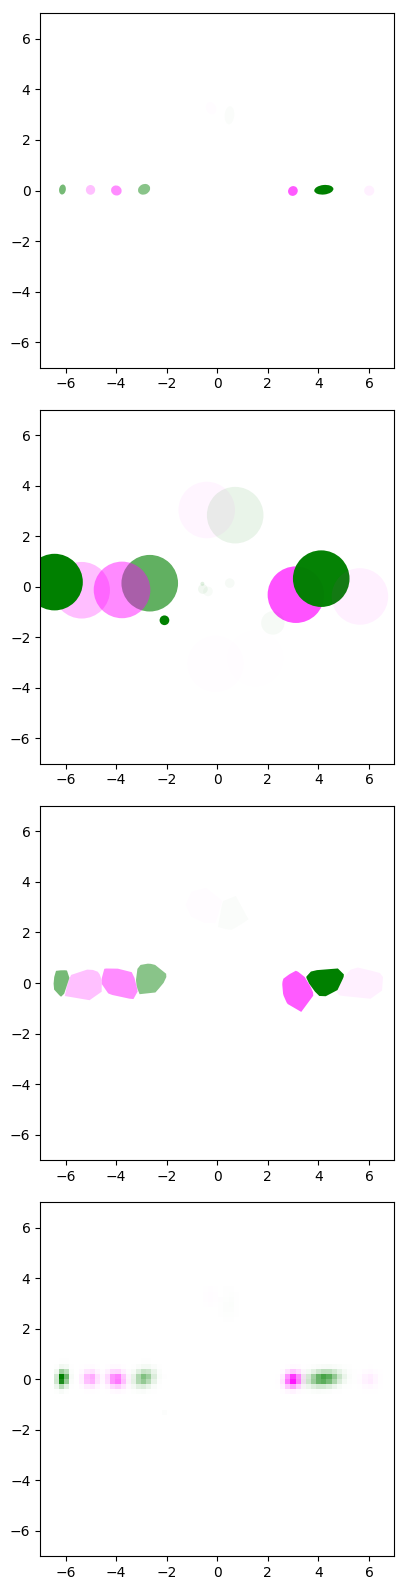

In [10]:
fig,ax = plt.subplots(4, figsize=(4,16), dpi=100)
cder.plot(ax[0], style="gaussians")
cder.plot(ax[1], style="covertree")
cder.plot(ax[2], style="hulls")
cder.plot(ax[3], style="heatmap")
for i in range(4):
    ax[i].set_aspect('equal')
    ax[i].set_xlim(-7,7)
    ax[i].set_ylim(-7,7)
plt.tight_layout()
plt.show()

Entropy
-------

Let's see how many "bits of certainty" we gained with these Gaussians
Also, for comparison, I'll use Bokeh this time to plot interactively

In [11]:
#import bokeh.plotting, bokeh.io
#bokeh.io.output_notebook()
#
#ax = bokeh.plotting.figure()
#cder.plot(ax, style="entropy")
#bokeh.io.show(ax)

Testing 
-------

Let's run the testing set against the model.

In [12]:
score = cder.score(clouds_test, labels_test)
numerator = np.count_nonzero(score)
denominator = score.shape[0]
print("Accuracy is {}%".format(100.0*numerator/denominator))

Accuracy is 100.0%


Cross-Validation
----------------

We should always run a CV, to be sure we aren't fooling ourselves

In [13]:
cder = CDER(parsimonious=True)
results = cross_val_score(cder, clouds_all, labels_all, scoring='accuracy', cv=5)
print(results)

[ 1.  1.  1.  1.  1.]
